# Actor-Critic evaluation

Plan:
- ~~Spike Actor-Critic~~
- ~~Quick test on a Gym env~~
- ~~Update requirements.txt~~
- ~~Move Actor-Critic out~~
- Make training records for analysis
- Structure next code

## Imports & setup

### Essential tools

In [42]:
# Generic setup
# from typing import Tuple
from collections import namedtuple

In [43]:
# Analysis
from IPython.display import clear_output

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

### Examine Gym environments

In [44]:
# %%capture
# from gym import envs
# print(envs.registry.all())

In [45]:
import gym

In [46]:
# Smoke test
# env = gym.make("CartPole-v1")
# # Check environment details
# CartPole-v0 is 200, 195.0
# CartPole-v1 is 500, 475.0
# env.spec.max_episode_steps, env.spec.reward_threshold, env.action_space, env.observation_space

# Rememeber to make reproducible gym environments
# env.seed(0)

### Import PyTorch

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducible results
torch.manual_seed(0)

### Import local modules

In [48]:
from actor_critic import ActorCritic

## Set up evaluation

https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f

Doing A2C, a single worker variant of A3C.
- backprop
- keep the hidden layer simple
- RMSprop as loss function
- reward step size/evaluation step size 5

Hyperparameters:
(values from Deep Reinforcement Learning Hands-On)
- num of envs used [20, 40, 60, 80, 100] <-- do 5 separate big experiments
- batch size [16, 32, 64]
- learning rate [0.001, 0.002, 0.003]
- entropy beta? [0.02, 0.03]
- hidden layers? (nah)

Analysis:
- Average reward
- No. of timesteps per episode (before terminating state)
- entropy loss?
- policy loss
- value loss
- (implied) Collect reward, timesteps elapsed

Gym CartPole V0 & V1 description:


>A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.




In [49]:
Results = namedtuple("Results", "episode_index, timesteps_elapsed, total_reward_per_episode")

def plot_rewards_episodes(reward):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title("episodes vs reward")
    plt.plot(reward)
    plt.show()
    
def plot_timesteps_episodes(timesteps_elapsed):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.title("episodes vs timesteps")
    plt.plot(timesteps_elapsed)
    plt.show()

In [50]:
env = gym.make("CartPole-v1")
env.seed(0)

# Parameters based on environment:
NUM_OBSERVATIONS: int = env.observation_space.shape[0] # input
NUM_ACTIONS: int = env.action_space.n # output
# NUM_ACTIONS, NUM_OBSERVATIONS

ac = ActorCritic(NUM_OBSERVATIONS, NUM_ACTIONS, (12, 12)).to(device)
# print(ac)
# print(vars(ac))

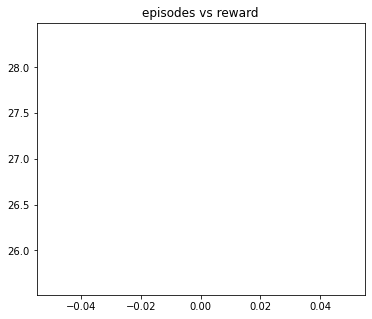

100%|██████████| 100/100 [00:30<00:00,  3.28it/s]


In [51]:
# One episode
def do_one_episode(env: gym.Env):
    state = env.reset()
    done = False

    total_reward = 0
    timestep_counter = 0

    while not done:
        state = torch.unsqueeze(torch.FloatTensor(state), 0).to(device)
        probability_dist, values = ac(state)
        action_to_take = probability_dist.sample()
        next_state, reward, done, _ = env.step(action_to_take.cpu().detach().numpy()[0])
        state = next_state

        total_reward += reward
        timestep_counter += 1

    return total_reward, timestep_counter

In [ ]:
# Reset
cartpole = gym.make("CartPole-v1")
episode_counter = 0
NUM_EPISODES = range(100)
results_list = []
test_rewards = []

# Three terminating states for CartPole-v1:
# env.spec.max_episode_steps 500
# env.spec.reward_threshold 475.0
# falls over

for i in tqdm(NUM_EPISODES):
    reward, timesteps_elapsed = do_one_episode(cartpole)
    episode_counter += 1
    results_list.append(Results(episode_index=episode_counter, timesteps_elapsed=timesteps_elapsed, total_reward_per_episode=reward))
    plot_rewards_episodes(results_list)
    # plot_timesteps_episodes(timesteps_elapsed)

    # print(reward, timesteps_elapsed)

## Prepare for analysis
### Transfer results into Pandas DF
### Write results to csv

In [52]:
results_df = pd.DataFrame(results_list)
results_df.head()

# results_df.to_csv
# The idea is that for each set experiment hyperparameters, we just add the columns of those values to the df and then save to csv


NameError: name 'plot' is not defined